<a href="https://colab.research.google.com/github/mthsansu/MLNLP/blob/main/Code/Houri_Sansu_PoliTweets_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>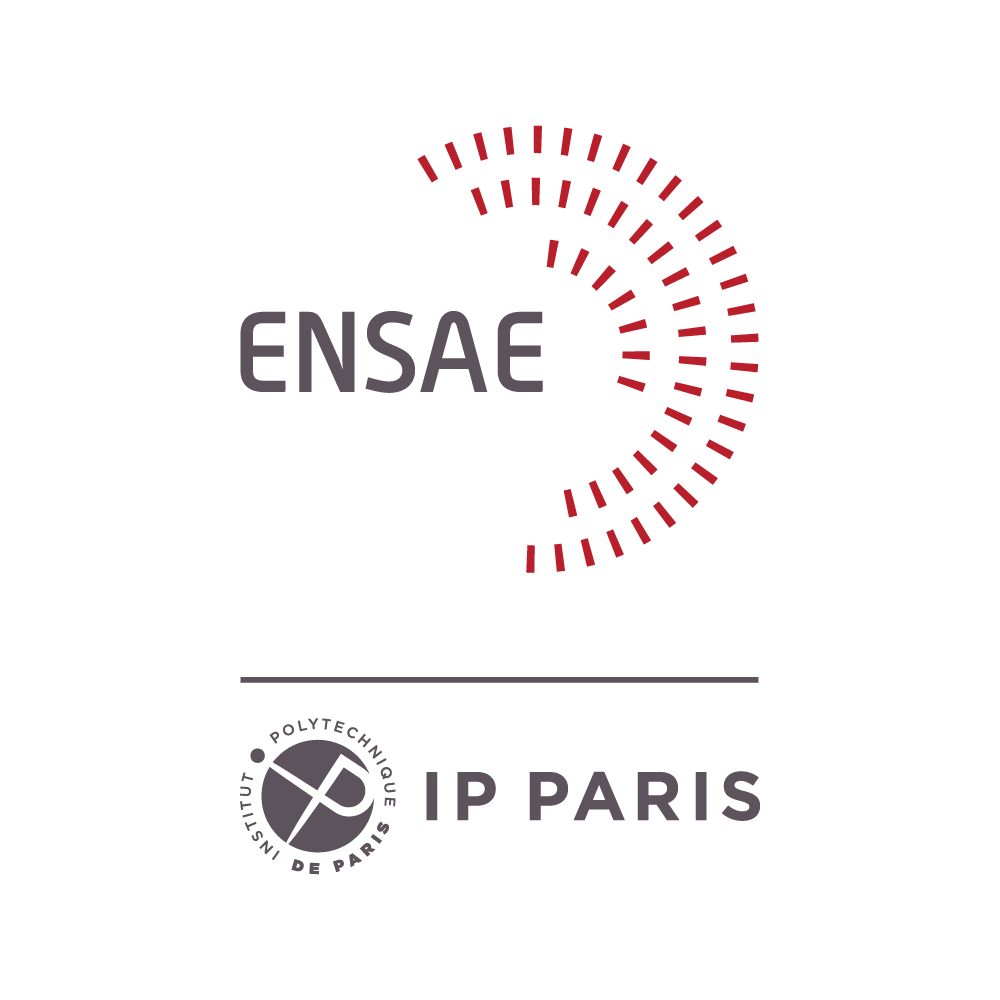</center>

<h1><center><strong><font color="chillipepper"> Machine Learning for Natural Language Processing</font></strong></center></h1>
<h3><center><font color="green"><strong>Yasmine Houri and Mathis Sansu</strong></font></center></h3>

<center>
April 2022 
</center>

# <font color="chillipepper">**Imports and Installation**</font>

In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 3.8 MB 26.4 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 596 kB 61.0 MB/s 
     |████████████████████████████████| 6.5 MB 61.6 MB/s 
     |████████████████████████████████| 895 kB 71.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 15.8 MB/s 


In [ ]:
import os
import time
import datetime
import random
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from scipy.special import softmax
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,precision_recall_fscore_support, confusion_matrix

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import CamembertTokenizer, CamembertConfig,\
                         AdamW, get_linear_schedule_with_warmup,\
                         WEIGHTS_NAME, CONFIG_NAME

from transformers import CamembertForSequenceClassification
from termcolor import colored

import re

# <font color="chillipepper">**GPU Settings**</font>

In [ ]:
# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))
device = torch.device(device)

DEVICE =  Tesla T4


In [ ]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

def encode(sentences, labels=None, tokenizer=tokenizer, batch_size=32, progress_bar=True):
    input_ids = []
    if progress_bar:
        sent_loader = tqdm(sentences)
    else:
        sent_loader = sentences
    for sent in sent_loader:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.  
        encoded_sent = tokenizer.encode(sent,                       # Sentence to encode.
                                        add_special_tokens = True   # Add '[CLS]' and '[SEP]'
                                        #max_length = 128,          # Truncate all sentences.
                                        #return_tensors = 'pt',     # Return pytorch tensors.
                                       )
        input_ids.append(encoded_sent)
        
    MAX_LEN = min(max([len(sen) for sen in input_ids]), 512)

    # Pad our input tokens with value 0.
    # "post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning.
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")

    # Create attention masks
    attention_masks = []
    if progress_bar:
        input_loader = tqdm(input_ids)
    else:
        input_loader = input_ids
    for sent in input_loader:
        # Create the attention mask.
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]

        attention_masks.append(att_mask)
    
    if labels is None:
        # Convert to pytorch tensors
        inputs_tensors = torch.tensor(input_ids)
        masks_tensors = torch.tensor(attention_masks)

        # Create the DataLoader 
        data = TensorDataset(inputs_tensors, masks_tensors)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return dataloader        
    else:
        # Convert to pytorch tensors
        inputs_tensors = torch.tensor(input_ids)
        masks_tensors = torch.tensor(attention_masks)
        labels_tensors = torch.tensor(labels)

        # Create the DataLoader 
        data = TensorDataset(inputs_tensors, masks_tensors, labels_tensors)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return dataloader
    
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded)) # Format as hh:mm:ss

def run_training(train_dataloader, 
                 test_dataloader, 
                 n_epochs=3, 
                 lr=5e-5, 
                 seed_val=2018, 
                 save_model_as=None):
    
    # Unpack all test labels for evaluation
    test_labels = []
    for batch in test_dataloader:
        test_labels += batch[2].numpy().tolist()
    num_labels = np.unique(test_labels).size
    
    # Set the seed value all over the place to make this reproducible.
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
    # Load model
    model = CamembertForSequenceClassification.from_pretrained("camembert-base", 
                                                               num_labels = num_labels, 
                                                               output_attentions = False, 
                                                               output_hidden_states = False)
    # Tell pytorch to run this model on the GPU.
    model.cuda()
    
    optimizer = AdamW(model.parameters(), lr = lr, eps = 1e-8)
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(train_dataloader) * n_epochs)
    #total number of training steps is number of batches * number of epochs.

    # Store the average loss after each epoch so we can plot them.
    train_loss_values = []
    test_loss_values = []
    
    for i_epoch in range(n_epochs):
    # each epoch
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.
        
        print("")
        print('======== Epoch {:} / {:} ========'.format(i_epoch + 1, n_epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total train loss for this epoch.
        total_train_loss = 0
        total_test_loss = 0  # Reset the total train loss for this epoch.


        # Put the model in training mode
        model.train()

        for step, train_batch in enumerate(train_dataloader):
        # each batch
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_inputs = train_batch[0].to(device)
            b_masks = train_batch[1].to(device)
            b_labels = train_batch[2].to(device)

            # Clear any previously calculated gradients before performing a
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we have provided the `labels`.
            outputs = model(b_inputs, token_type_ids=None, attention_mask=b_masks,labels=b_labels)

            # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1. This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()
            
            
        # Calculate the average loss over the training data batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Store the loss value for plotting the learning curve.
        train_loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
        model.eval()

        logits_complete = [] # store logits of each batch

        # Evaluate data for one epoch
        for test_batch in test_dataloader:
            # Add batch to GPU
            b_inputs = test_batch[0].to(device)
            b_masks = test_batch[1].to(device)
            b_labels = test_batch[2].to(device)

            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():        
                # Forward pass, calculate test loss and logit predictions.
                # token_type_ids = None : it's not 2-sentences task
                outputs = model(b_inputs, token_type_ids=None, attention_mask=b_masks,labels=b_labels)

            loss = outputs[0].item() # get loss
            logits = outputs[1]      # get logits
            
            # Move logits CPU
            logits = logits.detach().cpu().numpy()
            #labels_id = b_labels.to('cpu').numpy()
            
            total_test_loss += loss
            logits_complete.append(logits)
            
        logits_complete = np.concatenate(logits_complete)
        
        # Calculate the average loss over the test data batches.
        avg_test_loss = total_test_loss / len(test_dataloader)            
        # Store the loss value for plotting the learning curve.
        test_loss_values.append(avg_test_loss)
        
        print("")
        print("  Average test loss: {0:.2f}".format(avg_test_loss))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        print(classification_report(test_labels, np.argmax(logits_complete, axis=1).flatten()))
        score = precision_recall_fscore_support(test_labels, np.argmax(logits_complete, axis=1).flatten())


    
        
    # End of all epochs
    print("")
    print("Training complete!")
    
    
    if save_model_as is not None:
        # SAVE
        output_dir = "./models/{}".format(save_model_as)
        try:
            os.makedirs(output_dir)
        except:
            pass
        # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

        # If we have a distributed model, save only the encapsulated model
        # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
        model_to_save = model.module if hasattr(model, 'module') else model

        # If we save using the predefined names, we can load using `from_pretrained`
        output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
        output_config_file = os.path.join(output_dir, CONFIG_NAME)

        torch.save(model_to_save.state_dict(), output_model_file)
        model_to_save.config.to_json_file(output_config_file)
        tokenizer.save_vocabulary(output_dir)


    return score


def predict(dataloader, model, proba=True, progress_bar=True):
    logits_complete = []
    # Evaluate data for one epoch
    if progress_bar:
        loader = tqdm(dataloader)
    else:
        loader = dataloader
    for batch in loader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        if len(batch)==3:
            b_input_ids, b_input_mask, _ = batch
        else:
            b_input_ids, b_input_mask = batch


        # Telling the model not to compute or store gradients, saving memory andspeeding up validation
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None,  # not a 2-sentence task
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        logits_complete.append(logits)
        
        del outputs        
        torch.cuda.empty_cache() #release GPU memory
        
        pred = np.concatenate(logits_complete) #flatten batches
    if proba:
        return softmax(pred, axis=1)
    else:
        return pred
    
def predict_with_model(dataloader, model_path, proba=True):
    model = CamembertForSequenceClassification.from_pretrained(model_path)
    model.cuda()
    return predict(dataloader, model, proba)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

# <font color="chillipepper">**Data Download**</font>

In [ ]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
df = pd.read_csv("df_label_sentiment.csv")

# <font color="chillipepper">**Data Exploration**</font>

In [ ]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df

,X,text,possibly_sensitive,created_at,twitter.x,sexe,Label,sentiment,test
0,248552,"Article de Var Matin, ce jour, sur la proposit...",False,2021-05-08,famatras,M,0,0,True
1,592816,Je me réjouis de l’annonce du @gouvernementFR ...,False,2019-11-22,SandrineLeFeur,F,1,1,True
2,11907,"Une fois guéris, les enfants hospitalisés au @...",False,2019-08-09,AdrienTaquet,M,1,1,True
3,74888,« Progressivement nous devons avoir une foncti...,False,2018-03-21,auroreberge,F,0,1,False
4,253273,"Réaction commune, avec ma collègue députée Sab...",False,2018-02-22,fabiennecolboc,F,0,0,True
...,...,...,...,...,...,...,...,...,...
995,81617,Le président de l'ONG #ASER qui lutte contre l...,False,2019-10-02,lachaudb,M,-1,-1,True
996,407056,Masques fournis à tous les élèves et étudiants...,False,2020-08-23,DeputeCausse,M,0,0,True
997,224729,Le nouveau monde macronien est celui de la dég...,False,2018-09-06,ECiotti,M,-1,-1,True
998,231496,"""Depuis le 2 Mai, l'Elysée sait que M. Benalla...",False,2018-07-23,ericcoquerel,M,-1,-1,True


In [ ]:
def clean(text):
    # Removing mention
    text = re.sub("@[A-Za-z0-9_]+","", text)
    # Removing link
    text = re.sub(r'http\S+', '', text)
    # Removing new line
    text = text.replace('\n',' ')
    # Removing hash
    text = re.sub('#', '', text)
    # Remove additional spaces
    text = re.sub(' +', ' ', text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # no emoji
    return text

In [ ]:
df["text"] = df["text"].apply(lambda x: clean(x))
df = df.rename(columns={"sentiment":"value"})
df = df[["text","value"]]
df.value = df.value.replace(-1,2)
df.tail()

,text,value
995,Le président de l'ONG ASER qui lutte contre le...,2
996,Masques fournis à tous les élèves et étudiants...,0
997,Le nouveau monde macronien est celui de la dég...,2
998,"""Depuis le 2 Mai, l'Elysée sait que M. Benalla...",2
999,Afin d’associer directement les Français aux a...,0


In [ ]:
df.value.value_counts()

0    443
1    305
2    252
Name: value, dtype: int64

In [ ]:
train, test = train_test_split(df, test_size=0.2)

In [ ]:
train_dataloader = encode(train.text.values, train.value.values, batch_size=32)
test_dataloader = encode(test.text.values, test.value.values, batch_size=256)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
train_dataloader

In [ ]:
score = run_training(train_dataloader, 
                                  test_dataloader, 
                                  n_epochs=3, 
                                  lr=5e-5, 
                                  seed_val=2018, 
                                  save_model_as="social_tweet")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'


======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.03
  Training epcoh took: 0:00:33

Running Validation...

  Average test loss: 0.88
  Validation took: 0:00:05
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        88
           1       0.69      0.62      0.65        56
           2       0.85      0.61      0.71        56

    accuracy                           0.74       200
   macro avg       0.75      0.71      0.72       200
weighted avg       0.75      0.74      0.73       200


======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.74
  Training epcoh took: 0:00:33

Running Validation...

  Average test loss: 0.64
  Validation took: 0:00:05
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        88
           1       0.86      0.68      0.76        56
           2       0.83      0.80      0.82        56

    accuracy                         

In [ ]:
predict_loader = encode(test.text.values)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
pred = predict_with_model(predict_loader, model_path='./models/social_tweet/', proba=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
test['pred'] = np.argmax(pred, axis=1)

In [ ]:
test['prob_1'] = pred[:,1]

In [ ]:
test

,text,value,pred,prob_1
409,"Nous avons examiné en CF, les budgets de la Po...",0,0,0.146375
688,Présent au CampusTouquet des organisé par pour...,1,0,0.162236
640,Merci à d'avoir démontré la supercherie de Quo...,2,2,0.252058
175,"""Les idées, la connaissance, l'art, les voyage...",2,2,0.161049
656,<U+0001F4C6> Voici mon agenda de la semaine éc...,0,0,0.144517
...,...,...,...,...
700,« Nous sommes en train de réunir les ingrédien...,1,1,0.495212
578,Permettez-moi de vous souhaiter de bonnes fête...,0,2,0.310921
155,"Réunion ""se nourrir"" : refuse de taxer les pro...",2,2,0.139745
112,"En cas de ViolencesPolicières, nous proposons ...",2,0,0.137317


In [ ]:
test.pred.value_counts()

0    84
2    63
1    53
Name: pred, dtype: int64

In [ ]:
cfm = confusion_matrix(test.value.tolist(),test.pred.tolist())

In [ ]:
cfm

array([[70,  7, 11],
       [ 9, 43,  4],
       [ 5,  3, 48]])